In [56]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np

In [6]:
glazing_type=3 #set 1 for single glazing, 2 for double glazing, 3 for triple glazing


epw_file='casaccia_ENEA-hour.epw'

if glazing_type==1:
    filename='single.idf'
elif glazing_type==2:
    filename='double.idf'
elif glazing_type==3:
    filename='triple.idf'
else:
    print('Error in the model selection')
    
building = ef.get_building('IDFs/'+filename)

<_io.TextIOWrapper name='casaccia_ENEA-hour.epw' mode='r' encoding='cp1252'>

In [77]:
materials_list=[materials.Name for materials in building.idfobjects["MATERIAL"]] # get a list of the Name property of all IDF objects of class MATERIAL
print(materials_list)

['Gypsum Plastering_.02', 'Brick_.2', 'Masonry - mediumweight Dry_.2', 'Mortar_.03', 'Ceramic/porcelain_.01', 'Cement/plaster/mortar - cement plaster_.015', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015', 'Painted Oak_.035', 'EPS Expanded Polystyrene (Heavyweight)_.001', 'Brickwork Outer_.1', 'XPS Extruded Polystyrene  - CO2 Blowing_.0795', 'Concrete Block (Medium)_.1', 'Gypsum Plastering_.013']


In [78]:
cons = building.idfobjects["CONSTRUCTION"] #select the constructions
print (cons)

[
Construction,
    LinearBridgingConstruction,    !- Name
    LinearBridgingLayer;      !- Outside Layer
, 
Construction,
    IRTSurface,               !- Name
    IRTMaterial;              !- Outside Layer
, 
Construction,
    internal floor 46cm,      !- Name
    Gypsum Plastering_.02,    !- Outside Layer
    Brick_.2,                 !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Mortar_.03,               !- Layer 4
    Ceramic/porcelain_.01;    !- Layer 5
, 
Construction,
    internal floor 46cm_Rev,    !- Name
    Ceramic/porcelain_.01,    !- Outside Layer
    Mortar_.03,               !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Brick_.2,                 !- Layer 4
    Gypsum Plastering_.02;    !- Layer 5
, 
Construction,
    internal floor 46cm_Reversed,    !- Name
    Ceramic/porcelain_.01,    !- Outside Layer
    Mortar_.03,               !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Brick_.2,                 !- Layer 4
  

In [79]:
surfaces = building.idfobjects['BUILDINGSURFACE:DETAILED'] #select all the surfaces
s_names = [surface.Name for surface in surfaces] #get the name of the surfaces
vertical_walls = [sf for sf in surfaces if (sf.tilt == 90.0 and sf.Outside_Boundary_Condition=='Outdoors')] #isolate vertical outdoor walls
print ([sf.Construction_Name for sf in vertical_walls])

['Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm']


In [80]:
con_change=[con for con in cons if con.Name in [sf.Construction_Name for sf in vertical_walls]]
print (con_change)

[
Construction,
    Copy of Uninsulated Wall 53cm,    !- Name
    Cement/plaster/mortar - cement plaster_.015,    !- Outside Layer
    EPS Expanded Polystyrene (Heavyweight)_.001,    !- Layer 2
    Masonry - heavyweight Dry_.5,    !- Layer 3
    Gypsum Plastering_.015;    !- Layer 4
]


In [81]:
mat_select=[mat.fieldvalues[2:] for mat in con_change] #select the materials of the wall; starting from the second element as the first is the name 
print(mat_select)
mat_change=[mat for mat in materials_list for i in mat_select if mat in i]
print(mat_change)

[['Cement/plaster/mortar - cement plaster_.015', 'EPS Expanded Polystyrene (Heavyweight)_.001', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015']]
['Cement/plaster/mortar - cement plaster_.015', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015', 'EPS Expanded Polystyrene (Heavyweight)_.001']


In [82]:
insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795', field_name='Thickness') #creating the insulation parameter
thickness=RangeParameter(min_val = 0.01, max_val=0.35)
insulation_param = Parameter(selector=insulation,
                                 value_descriptor=thickness,
                                 name='Insulation Thickness')
print(insulation_param)

Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[RangeParameter(min=0.01, max=0.35)])


/home/ict4bd/py3/lib/python3.9/site-packages/besos-2.1.3-py3.9.egg/besos/parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


In [83]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [84]:
for natural_ventilation in building.idfobjects["ZoneVentilation:DesignFlowRate"]:
            natural_ventilation.Design_Flow_Rate_Calculation_Method='AirChanges/Hour'

ventilation = FieldSelector(class_name='ZoneVentilation:DesignFlowRate', object_name='*', field_name='Air Changes per Hour')#creating the ACH parameter
ventilation_interval = RangeParameter(min_val = 0, max_val=6)
ventilation_param=Parameter(selector=ventilation, value_descriptors=ventilation_interval, name='ACH')

shading_solar = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint 2')#creating the irradiation parameter for shading
shading_solar_interval = RangeParameter(min_val = 80, max_val = 300)
shading_solar_param=Parameter(selector=shading_solar, value_descriptors=shading_solar_interval, name='Irradiation')

shading_temp = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint')#creating the temperature parameter for shading
shading_temp_interval = RangeParameter(min_val = 18, max_val = 28)
shading_temp_param=Parameter(selector=shading_temp, value_descriptors=shading_temp_interval, name='Temperature')

parameters=[insulation_param] + [shading_solar_param] + [shading_temp_param] + [ventilation_param]
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=120)

print(samples)


     Insulation Thickness  Irradiation  Temperature       ACH
0                0.200037   174.620550    24.828402  4.278206
1                0.333473   249.447989    22.046593  5.794528
2                0.106819   161.117480    24.886473  2.245511
3                0.240470   293.655226    27.373060  3.248114
4                0.249443   121.817890    25.833983  4.612092
..                    ...          ...          ...       ...
115              0.214739   209.758469    22.377215  0.043865
116              0.244119   286.100938    21.834171  4.849499
117              0.301545   183.250741    24.999535  5.997385
118              0.128647   229.022725    25.517021  1.573759
119              0.317954   235.155107    27.032262  5.840716

[120 rows x 4 columns]


In [85]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw=epw_file)
outputs = evaluator.df_apply(samples, keep_input=True)

outputs.describe()

Executing:   0%|          | 0/120 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:22


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:23


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:23


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:24


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:25


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:25


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:26


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:26


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:27


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:27


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:28


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:28


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:29


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:29


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:30


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:31


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:31


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:32


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:32


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:33


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:33


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:34


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:34


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:35


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:36


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:36


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:38


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:38


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:39


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:39


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:40


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:40


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:41


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:42


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:42


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:43


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:43


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:44


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:44


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:45


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:45


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:46


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:46


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:47


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:48


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:48


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:49


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:49


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:50


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:50


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:51


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:51


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:52


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:53


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:53


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:54


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:54


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:55


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:55


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:56


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:56


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:57


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:58


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:58


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:59


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 15:59


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:00


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:00


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:01


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:01


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:02


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:03


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:03


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:04


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:04


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:05


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:05


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:06


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:06


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:07


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:07


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:08


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:09


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:09


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:10


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:10


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:11


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:11


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:12


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:12


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:13


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:14


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:14


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:15


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:15


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:16


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:16


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:17


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:17


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:18


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:18


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:19


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:20


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:20


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:21


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:21


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:22


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:22


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:23


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:23


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:24


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:25


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:25


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:26


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:26


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:27


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:27


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption F

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.03.30 16:28


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL FLOOR 46CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializi

EnergyPlus Completed Successfully.


,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,120.000000,120.000000,120.000000,120.000000,1.200000e+02,1.200000e+02,1.200000e+02
mean,0.180010,190.054085,23.001293,3.002579,1.404464e+10,2.598352e+10,1.779521e+10
std,0.098664,63.801020,2.897450,1.738651,7.185478e+04,2.171971e+08,6.854822e+08
min,0.011883,81.586527,18.001675,0.043865,1.404461e+10,2.575402e+10,1.640227e+10
25%,0.096381,135.503020,20.528209,1.501730,1.404461e+10,2.582537e+10,1.731737e+10
50%,0.179551,189.625407,23.007139,3.008767,1.404461e+10,2.590636e+10,1.773051e+10
75%,0.264148,244.311665,25.460591,4.472763,1.404462e+10,2.608656e+10,1.833326e+10
max,0.348613,299.636549,27.941806,5.997385,1.404503e+10,2.663226e+10,1.933376e+10


Text(0, 0.5, 'DistrictCooling:Facility')

<Figure size 432x288 with 0 Axes>

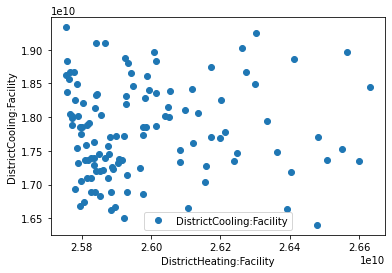

In [87]:
plt.figure()
_ = outputs.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])

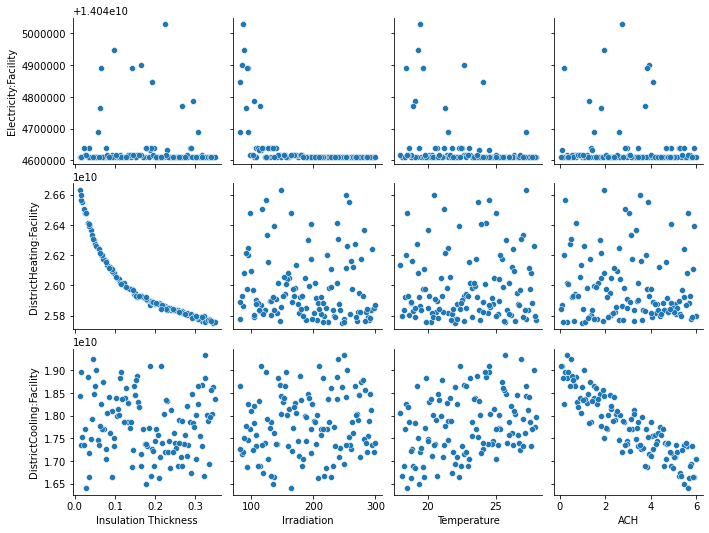

In [89]:
_=pairplot(outputs,x_vars=samples.columns, y_vars=objectives, kind="scatter")

In [90]:
outputs=outputs/10e6
outputs.corr()

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Insulation Thickness,1.000000,0.167461,-0.050447,0.116288,-0.051572,-0.911235,-0.065611
Irradiation,0.167461,1.000000,0.092064,0.094780,-0.500857,-0.093821,0.122445
Temperature,-0.050447,0.092064,1.000000,0.099958,-0.275596,0.062039,0.308133
ACH,0.116288,0.094780,0.099958,1.000000,-0.058404,-0.076532,-0.889998
Electricity:Facility,-0.051572,-0.500857,-0.275596,-0.058404,1.000000,-0.004385,-0.177834
DistrictHeating:Facility,-0.911235,-0.093821,0.062039,-0.076532,-0.004385,1.000000,0.045774
DistrictCooling:Facility,-0.065611,0.122445,0.308133,-0.889998,-0.177834,0.045774,1.000000


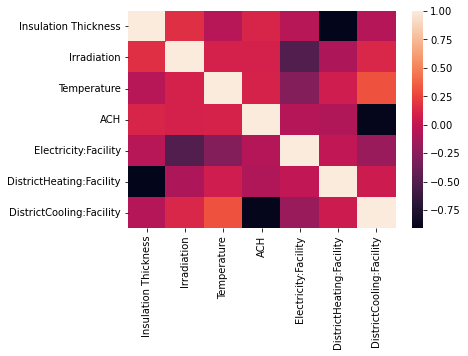

In [91]:
_ = heatmap(outputs.corr())

In [92]:
outputs=outputs*10e6
outputs["TotConsumption"] = outputs["DistrictCooling:Facility"] + outputs["DistrictHeating:Facility"] +  outputs["Electricity:Facility"]
outputs

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
0,0.200037,174.620550,24.828402,4.278206,1.404461e+10,2.587826e+10,1.744824e+10,5.737112e+10
1,0.333473,249.447989,22.046593,5.794528,1.404461e+10,2.578023e+10,1.693508e+10,5.675993e+10
2,0.106819,161.117480,24.886473,2.245511,1.404461e+10,2.604888e+10,1.815147e+10,5.824496e+10
3,0.240470,293.655226,27.373060,3.248114,1.404461e+10,2.583880e+10,1.813196e+10,5.801537e+10
4,0.249443,121.817890,25.833983,4.612092,1.404461e+10,2.583548e+10,1.738908e+10,5.726918e+10
...,...,...,...,...,...,...,...,...
115,0.214739,209.758469,22.377215,0.043865,1.404461e+10,2.584101e+10,1.909964e+10,5.898526e+10
116,0.244119,286.100938,21.834171,4.849499,1.404461e+10,2.584175e+10,1.719777e+10,5.708413e+10
117,0.301545,183.250741,24.999535,5.997385,1.404461e+10,2.579902e+10,1.705510e+10,5.689873e+10
118,0.128647,229.022725,25.517021,1.573759,1.404461e+10,2.598824e+10,1.860708e+10,5.863993e+10


In [93]:
min_total_consumption=outputs.TotConsumption.min()
best_parameters=outputs[outputs.TotConsumption==min_total_consumption]
best_parameters

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
102,0.176925,134.366903,19.384022,5.447597,1.404464e+10,2.592057e+10,1.650233e+10,5.646754e+10
